In [20]:
import datetime
import os
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta

In [4]:
#Répertoire du fichier de données
PROCESSED_DIR = '../data/processed/'

# Table principale 
ALL_DATA_FILE =  'all_data.csv'

ENV_FILE = '../env.yaml'
with open(ENV_FILE) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)

# Initialisation des chemins vers les fichiers
ROOT_DIR = os.path.dirname(os.path.abspath(ENV_FILE))
DATA_FILE = os.path.join(ROOT_DIR, 
                         params['directories']['processed'], 
                         params['files']['all_data'])

# Lecture du fichiers des données
epidemie_df = (pd.read_csv(DATA_FILE, parse_dates=["Last Update"])
               .assign(day=lambda _df: _df['Last Update'].dt.date)
               .drop_duplicates(subset=['Country/Region', 'Province/State', 'day'])
               [lambda df: df.day <= datetime.date(2020, 3,12)]
              )

In [6]:
france_df = (epidemie_df[epidemie_df['Country/Region']== 'France']
             .groupby(['Country/Region','day'])
             .agg({'Confirmed': 'sum', 'Deaths':'sum','Recovered':'sum'})
             .reset_index()
            )

In [7]:
france_df['Confirmed'].diff()

0       NaN
1       1.0
2       0.0
3       0.0
4       1.0
5       1.0
6       0.0
7       0.0
8       1.0
9       5.0
10      0.0
11      1.0
12      2.0
13      4.0
14     20.0
15     19.0
16     43.0
17     30.0
18     61.0
19     13.0
20     81.0
21     92.0
22    276.0
23    296.0
24    177.0
25     83.0
26    575.0
27    503.0
Name: Confirmed, dtype: float64

In [13]:
def get_country(self, country):
    return (epidemie_df[epidemie_df['Country/Region']== country]
             .groupby(['Country/Region','day'])
             .agg({'Confirmed': 'sum', 'Deaths':'sum','Recovered':'sum'})
             .reset_index()   
           )

#Monkey Patch pd.DataFrame 
pd.DataFrame.get_country = get_country

In [14]:
korea_df = (epidemie_df[epidemie_df['Country/Region']== 'South Korea']
             .groupby(['Country/Region','day'])
             .agg({'Confirmed': 'sum', 'Deaths':'sum','Recovered':'sum'})
             .reset_index()
           )

In [15]:
italy_df = epidemie_df.get_country('Italy')
italy_df.head()

,Country/Region,day,Confirmed,Deaths,Recovered
0,Italy,2020-01-31,2.0,0.0,0.0
1,Italy,2020-02-07,3.0,0.0,0.0
2,Italy,2020-02-21,20.0,1.0,0.0
3,Italy,2020-02-22,62.0,2.0,1.0
4,Italy,2020-02-23,155.0,3.0,2.0


In [16]:
korea_df['infected'] = korea_df['Confirmed'].diff()
italy_df['infected'] = italy_df['Confirmed'].diff()

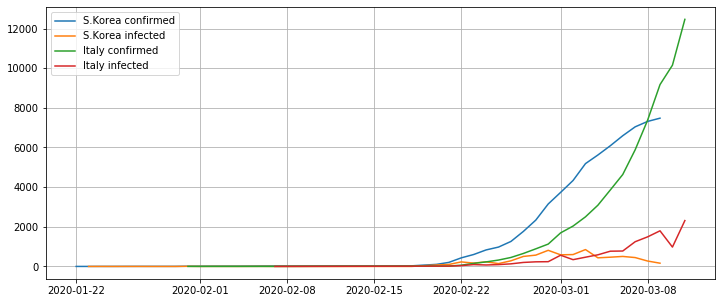

In [17]:
%matplotlib inline

fig = plt.figure(figsize=(12,5))
plt.plot(korea_df['day'], korea_df['Confirmed'], label='S.Korea confirmed')
plt.plot(korea_df['day'], korea_df['infected'],label='S.Korea infected')
plt.plot(italy_df['day'], italy_df['Confirmed'],label='Italy confirmed')
plt.plot(italy_df['day'], italy_df['infected'],label='Italy infected')
plt.grid(True)
plt.legend()
plt.show()

In [18]:
beta, gamma = [0.01, 0.1]

def SIR(t,y):
    S = y[0]
    I = y[1]
    R = y[2]
    return([-beta*S*I, beta*S*I-gamma*I,gamma*I])

In [23]:
from scipy.integrate import solve_ivp

beta, gamma = [0.01, 0.1]
solution_korea = solve_ivp(SIR, [0,40],[51_470_000,1,0], t_eval=np.arange(0,40,1))

In [24]:
solution_korea

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 10617824
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])
 t_events: None
        y: array([[ 5.14700000e+07,  2.04872617e-07, -5.79192642e-07,
        -1.02864803e-07,  3.39434814e-07,  1.95092383e-07,
         1.56908982e-06, -5.54756490e-07,  8.55639764e-07,
        -3.84005541e-07,  1.14854677e-06,  1.04737837e-06,
         1.41446345e-07, -3.89979213e-08, -1.31579840e-06,
        -1.17991062e-06, -5.32379870e-07,  6.79204480e-07,
        -7.21960552e-07, -4.83684927e-07, -5.40636688e-07,
         5.00739636e-09, -2.42491836e-07, -4.15623310e-07,
         5.38168115e-07, -1.20506229e-08,  4.33030631e-07,
        -5.17489767e-07,  6.52063146e-07, -1.73762585e-07,
         6.151133

In [25]:
def plot_epidemia(solution, infected, susceptible):
    fig = plt.figure(figsize=(12,5))
    plt.plot(solution.t,solution.y[0])
    plt.plot(solution.t,solution.y[1])
    plt.plot(solution.t,solution.y[2])
    plt.plot(infected.reset_index(drop=True).index, infected,"k*:")
    plt.grid('True')
    plt.legend(['Susceptible','Infected','Recovered','Original Data'])
    plt.show()

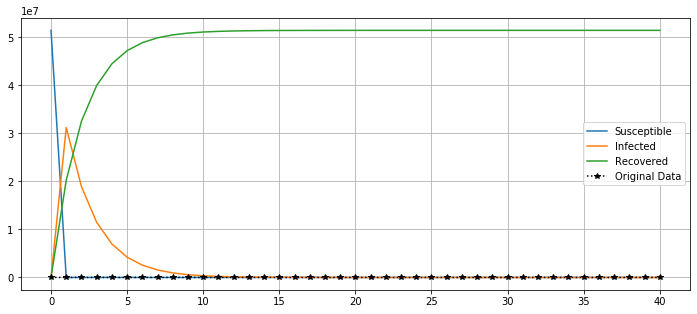

In [35]:
plot_epidemia(solution_korea,korea_df.loc[2:]['infected'])

In [34]:
beta, gamma = [0.001, 0.5]
solution_korea = solve_ivp(SIR, [0,40],[51_470_000,1,0], t_eval=np.arange(0,41,1))

In [47]:
def sumsq_error(parameters):
    beta, gamma = parameters
    
    def SIR(t,y):
        S = y[0]
        I = y[1]
        R = y[2]
        return([-beta*S*I, beta*S*I-gamma*I,gamma*I])

   
    solution = solve_ivp(SIR, [0,nb_steps-1],[total_population,1,0], t_eval=np.arange(0,nb_steps,1))
    
    return(sum((solution.y[1]-infected_population)**2))

In [48]:
total_population = 51_470_000

infected_population = korea_df.loc[2:]['infected']
nb_steps = len(infected_population)

In [74]:
beta_optimal = 1.5485e-7
gamma_optimal = 0.1839

beta_optimal_2 = 0.06
gamma_optimal_2 = 34

In [77]:
beta = beta_optimal
gamma = gamma_optimal
solution_korea_optimal = solve_ivp(SIR, [0,40],[51_470_000*0.1,1,0], t_eval=np.arange(0,40,1))

In [60]:
beta = beta_optimal_2
gamma = gamma_optimal_2
solution_korea_optimal_2 = solve_ivp(SIR, [0,40],[51_470_000,1,0], t_eval=np.arange(0,40,1))

In [49]:
%%time
from scipy.optimize import minimize


msol = minimize(sumsq_error, [0.001, 0.1], method= 'Nelder-Mead')
msol.x

KeyboardInterrupt: 

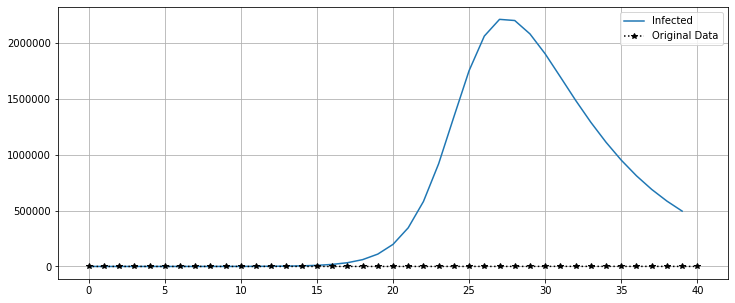

In [78]:
fig = plt.figure(figsize=(12, 5))
plt.plot(solution_korea_optimal.t, solution_korea_optimal.y[1])
plt.plot(korea_df.loc[2:]['infected'].reset_index(drop=True).index, korea_df.loc[2:]['infected'], "k*:")
plt.grid("True")
plt.legend(['Infected', "Original Data"])
plt.show()

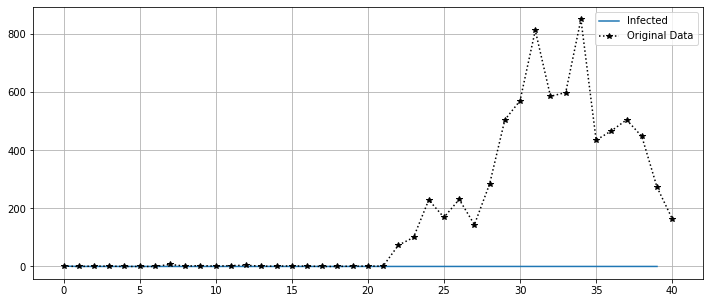

In [61]:
fig = plt.figure(figsize=(12, 5))
plt.plot(solution_korea_optimal_2.t, solution_korea_optimal.y[1])
plt.plot(korea_df.loc[2:]['infected'].reset_index(drop=True).index, korea_df.loc[2:]['infected'], "k*:")
plt.grid("True")
plt.legend(['Infected', "Original Data"])
plt.show()

In [68]:
china_df = epidemie_df.get_country('Mainland China')[:49]
china_df.head()

,Country/Region,day,Confirmed,Deaths,Recovered
0,Mainland China,2020-01-22,547.0,17.0,28.0
1,Mainland China,2020-01-23,639.0,18.0,30.0
2,Mainland China,2020-01-24,916.0,26.0,36.0
3,Mainland China,2020-01-25,1399.0,42.0,39.0
4,Mainland China,2020-01-26,2062.0,56.0,49.0


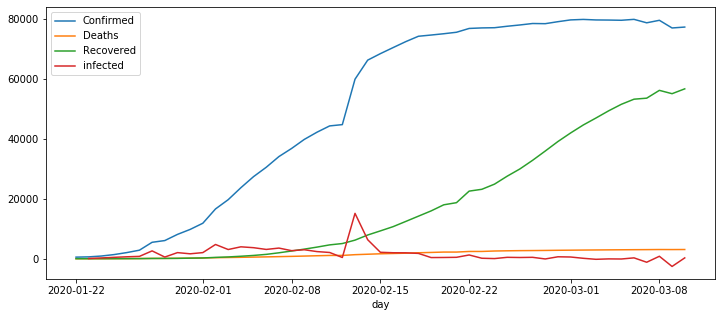

In [71]:
china_df.set_index('day').plot.line(figsize=(12,5));

In [70]:
beta, gamma = [0.001, 0.5]
china_df['infected'] = china_df['Confirmed'].diff()
nb_steps = china_df.shape[0]
solution_china = solve_ivp(SIR, [0,40],[1_350_000_000,1,0], t_eval=np.arange(0,41,1))

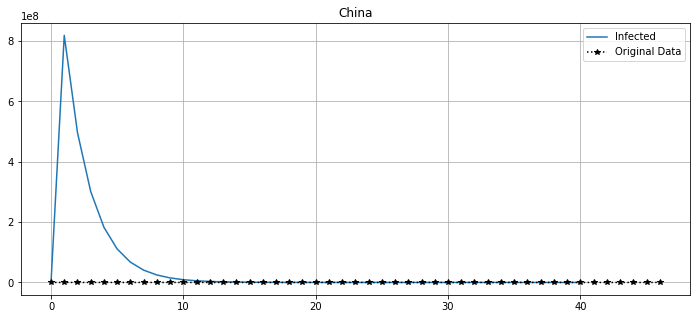

In [72]:
fig = plt.figure(figsize=(12, 5))
plt.plot(solution_china.t, solution_china.y[1])
plt.plot(china_df.loc[2:]['infected'].reset_index(drop=True).index, china_df.loc[2:]['infected'], "k*:")
plt.title('China')
plt.grid("True")
plt.legend(['Infected', "Original Data"])
plt.show()

In [73]:
solution_china

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 5672666
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40])
 t_events: None
        y: array([[ 1.35000000e+09, -5.01325430e-07,  6.81826743e-07,
         1.66298346e-07,  8.99183611e-08,  4.60751925e-07,
         8.50804654e-07, -6.25032038e-07, -6.82717568e-07,
        -9.20251622e-07, -4.24705593e-07, -4.15660183e-07,
         4.65430636e-07,  1.23395569e-06, -6.82206816e-07,
         1.36199790e-07, -6.21715324e-07, -1.17169948e-07,
        -2.47863592e-07,  1.71429321e-06,  1.28913077e-07,
        -3.50148356e-07, -8.89371166e-07,  2.09411278e-07,
         2.38423485e-07,  1.58458127e-07,  3.19813539e-08,
         6.59034195e-08,  5.04104345e-08,  1.48230972e-07,
         9.220